In [56]:
import pandas as pd
import zipfile
from elopy.elo import Elo
import heapq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score
import random
from scipy.stats import kendalltau

In [3]:
with zipfile.ZipFile('data/contest_results.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

In [4]:
df = pd.read_csv('./extracted_files/contest_results.csv', parse_dates=['contest_date'])
df.loc[df['placing'] > 16, 'placing'] = 16

In [5]:
df_pro = df[df['organization'] == 'ifbb']
df_pro_open = df_pro[df_pro['class'] == 'open']

In [6]:
df_pro_open.head()

,contest_url,competitor_name,competitor_url,organization,contest_name,contest_date,division,class,placing,scraped_timestamp,is_loaded
17027,https://contests.npcnewsonline.com/contests/20...,paula gulman-williams,https://contests.npcnewsonline.com/contests/20...,ifbb,ifbb flex pro,2012-02-18,fitness,open,12.0,2023-11-07 03:09:15.053933 UTC,False
17028,https://contests.npcnewsonline.com/contests/20...,michele mayberry,https://contests.npcnewsonline.com/contests/20...,ifbb,ifbb flex pro,2012-02-18,fitness,open,11.0,2023-11-07 03:09:15.053471 UTC,False
17029,https://contests.npcnewsonline.com/contests/20...,sheri vucick,https://contests.npcnewsonline.com/contests/20...,ifbb,ifbb flex pro,2012-02-18,fitness,open,10.0,2023-11-07 03:09:15.05299 UTC,False
17030,https://contests.npcnewsonline.com/contests/20...,allison ethier,https://contests.npcnewsonline.com/contests/20...,ifbb,ifbb flex pro,2012-02-18,fitness,open,9.0,2023-11-07 03:09:15.05247 UTC,False
17031,https://contests.npcnewsonline.com/contests/20...,camala rodriguez,https://contests.npcnewsonline.com/contests/20...,ifbb,ifbb flex pro,2012-02-18,fitness,open,8.0,2023-11-07 03:09:15.052009 UTC,False


In [6]:
df_pro = df_pro[['competitor_name', 'placing', 'contest_name', 'contest_date', 'division', 'class']]
df_pro_open = df_pro_open[['competitor_name', 'placing', 'contest_name', 'contest_date', 'division']]

In [7]:
# every pair of competitors from the same show & division get a row
# think of this as a "match" in chess
df_merge = pd.merge(df_pro,
                    df_pro,
                    on=['contest_name', 'contest_date', 'division', 'class'],
                    how='inner',
                    suffixes=('_winner', '_loser'))

df_merge_open = pd.merge(df_pro_open,
                    df_pro_open,
                    on=['contest_name', 'contest_date', 'division'],
                    how='inner',
                    suffixes=('_winner', '_loser'))

In [9]:
df_merge.head()

,competitor_name_winner,placing_winner,contest_name,contest_date,division,class,competitor_name_loser,placing_loser
0,paula gulman-williams,12.0,ifbb flex pro,2012-02-18,fitness,open,paula gulman-williams,12.0
1,paula gulman-williams,12.0,ifbb flex pro,2012-02-18,fitness,open,michele mayberry,11.0
2,paula gulman-williams,12.0,ifbb flex pro,2012-02-18,fitness,open,sheri vucick,10.0
3,paula gulman-williams,12.0,ifbb flex pro,2012-02-18,fitness,open,allison ethier,9.0
4,paula gulman-williams,12.0,ifbb flex pro,2012-02-18,fitness,open,camala rodriguez,8.0


In [8]:
df_merge = df_merge[df_merge['placing_winner'] < df_merge['placing_loser']]
df_merge_open = df_merge_open[df_merge_open['placing_winner'] < df_merge_open['placing_loser']]

In [9]:
df_merge = df_merge[['competitor_name_winner', 'placing_winner', 'competitor_name_loser', 'placing_loser', 'contest_date', 'contest_name', 'division', 'class']]
df_merge_open = df_merge_open[['competitor_name_winner', 'placing_winner', 'competitor_name_loser', 'placing_loser', 'contest_date', 'contest_name', 'division']]

In [12]:
df_merge.head()

,competitor_name_winner,placing_winner,competitor_name_loser,placing_loser,contest_date,contest_name,division,class
12,michele mayberry,11.0,paula gulman-williams,12.0,2012-02-18,ifbb flex pro,fitness,open
24,sheri vucick,10.0,paula gulman-williams,12.0,2012-02-18,ifbb flex pro,fitness,open
25,sheri vucick,10.0,michele mayberry,11.0,2012-02-18,ifbb flex pro,fitness,open
36,allison ethier,9.0,paula gulman-williams,12.0,2012-02-18,ifbb flex pro,fitness,open
37,allison ethier,9.0,michele mayberry,11.0,2012-02-18,ifbb flex pro,fitness,open


In [13]:
df_merge[df_merge['contest_name'].str.contains('olympia')]['contest_date'].value_counts()

contest_date
2022-12-13    4302
2023-11-03    2617
2016-12-28    2206
2021-12-30    2070
2014-06-10    1973
2018-09-14    1911
2015-09-17    1848
2017-09-15    1839
2020-12-18    1782
2019-09-13    1668
2014-09-18    1184
2012-09-28    1098
2013-09-26     988
2014-06-16     802
2012-12-06     390
2012-12-02     105
Name: count, dtype: int64

In [14]:
olympia_2022 = '2022-12-13'
olympia_2023 = '2023-11-03'

In [15]:
df_2023 = df_merge[df_merge['contest_date'] < olympia_2023]
df_2023 = df_2023.sort_values(by='contest_date', ascending=True)

In [16]:
# dictionary maps competitor name to their Elo rating class
competitors = {}

In [17]:
for index, row in df_2023.iterrows():
    winner = row['competitor_name_winner']
    loser = row['competitor_name_loser']
    rank_diff = row['placing_loser'] - row['placing_winner']
    if winner not in competitors:
        competitors[winner] = Elo()
    if loser not in competitors:
        competitors[loser] = Elo()
        
    competitors[winner].play_game(competitors[loser], rank_diff)

In [18]:
bikini_olympia = df_pro[(df_pro['contest_date'] == olympia_2023)
       & (df_pro['division'] == 'bikini')]['competitor_name'].unique()

bikini_olympia = [name for name in bikini_olympia if name in competitors]

In [19]:
top_ten = []
name_rating = [(-competitors[name].elo, name) for name in bikini_olympia]
heapq.heapify(name_rating)
for i in range(10):
    print(heapq.heappop(name_rating))

(-2278.997071660935, 'ashley kaltwasser')
(-2270.7277551699804, 'jennifer dorie')
(-2257.1958112947177, 'lauralie chapados')
(-2195.406290651582, 'elisa pecini')
(-2176.5894203897924, 'maureen blanquisco')
(-2122.735828730946, 'daraja hill')
(-2069.941998089539, 'romina basualdo')
(-2069.4682338519206, 'aimee leann delgado')
(-2025.5617500424798, 'jourdanne lee')
(-1983.3070900329278, 'ivanna escandar')


In [20]:
competitors['ashley kaltwasser'].win_probs(competitors['jourdanne lee'])


0.8843758458824753

In [21]:
df_2022 = df_merge[df_merge['contest_date'] < olympia_2022]
df_2022 = df_2022.sort_values(by='contest_date', ascending=True)

competitors = {}

for index, row in df_2022.iterrows():
    winner = row['competitor_name_winner']
    loser = row['competitor_name_loser']
    rank_diff = row['placing_loser'] - row['placing_winner']
    if winner not in competitors:
        competitors[winner] = Elo()
    if loser not in competitors:
        competitors[loser] = Elo()
    competitors[winner].play_game(competitors[loser], rank_diff)

bikini_olympia = df_pro[(df_pro['contest_date'] == olympia_2022)
       & (df_pro['division'] == 'bikini')]['competitor_name'].unique()

bikini_olympia = [name for name in bikini_olympia if name in competitors]

In [22]:
top_ten = []
name_rating = [(-competitors[name].elo, name) for name in bikini_olympia]
heapq.heapify(name_rating)
for i in range(10):
    print(heapq.heappop(name_rating))

(-2242.240323340484, 'lauralie chapados')
(-2236.585505267137, 'ashley kaltwasser')
(-2235.216539225168, 'janet layug')
(-2220.9980372560767, 'jennifer dorie')
(-2212.1110195844963, 'elisa pecini')
(-2061.807677715691, 'maureen blanquisco')
(-2060.564879736981, 'india paulino')
(-2042.5153008347124, 'romina basualdo')
(-2030.0138597997966, 'daraja hill')
(-2020.7686899396751, 'ashlyn little')


In [23]:
competitors['ashley kaltwasser'].win_probs(competitors['jennifer dorie'])

0.6604667612688553

# Elo Rating Column
Here we will create a column in df_pro which includes the competitor's Elo rating leading up to that competition.

In [10]:
df_pro_open = df_pro_open.sort_values(by=['contest_date', 'contest_name', 'division', 'competitor_name'], ascending=True)

In [11]:
competitors_open = {}

for k in range(10, 300, 50):
    competitors_open[k] = {}
    for contest_date in df_pro_open['contest_date'].unique():
        for index, row in df_pro_open[df_pro_open['contest_date'] == contest_date].iterrows():

            if row['competitor_name'] not in competitors_open[k]:
                competitors_open[k][row['competitor_name']] = Elo(k=k)

            df_pro_open.loc[index, f'elo_{k}_rating'] = competitors_open[k][row['competitor_name']].elo

        for index, row in df_merge_open[df_merge_open['contest_date'] == contest_date].iterrows():
            winner = row['competitor_name_winner']
            loser = row['competitor_name_loser']
            rank_diff = row['placing_loser'] - row['placing_winner']
                
            competitors_open[k][winner].play_game(competitors_open[k][loser], rank_diff)

    df_pro_open[f'elo_{k}_percentile'] = df_pro_open.groupby(['contest_date', 'contest_name', 'division'])[f'elo_{k}_rating'].rank(pct=True)

In [58]:
df_pro_open.tail()

,competitor_name,placing,contest_name,contest_date,division,elo_rating,elo_percentile,elo_rank,elo_10_rating,elo_10_percentile,...,elo_160_percentile,elo_210_rating,elo_210_percentile,elo_260_rating,elo_260_percentile,elo_310_rating,elo_310_percentile,elo_360_rating,elo_360_percentile,elo_410_rating
74414,ren yi xie,6.0,ifbb professional league china dms pro shanghai,2024-03-01,men's physique,1500.000000,0.5625,4.5,1500.000000,0.5625,...,0.6875,1500.000000,0.6875,1500.000000,0.6875,1500.000000,0.6875,1500.000000,0.6875,NaN
74415,xingwang yang,5.0,ifbb professional league china dms pro shanghai,2024-03-01,men's physique,1500.000000,0.5625,4.5,1500.000000,0.5625,...,0.6875,1500.000000,0.6875,1500.000000,0.6875,1500.000000,0.6875,1500.000000,0.6875,NaN
74416,abdullah al salem,4.0,ifbb professional league china dms pro shanghai,2024-03-01,men's physique,1530.254944,0.8750,6.0,1500.646795,0.7500,...,0.8750,1534.088927,0.8750,1531.441383,0.8750,1522.382672,0.8750,1512.350775,0.8750,NaN
74417,yiming wei,3.0,ifbb professional league china dms pro shanghai,2024-03-01,men's physique,1513.489760,0.7500,8.0,1519.870221,1.0000,...,0.5000,1483.231418,0.5000,1472.726432,0.5000,1461.331899,0.5000,1451.684278,0.5000,NaN
74419,carlos asiedu ocran,1.0,ifbb professional league china dms pro shanghai,2024-03-01,men's physique,1408.432332,0.3750,3.0,1482.297860,0.3750,...,0.3750,1362.113443,0.3750,1345.679987,0.3750,1330.092145,0.3750,1314.684267,0.3750,NaN


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


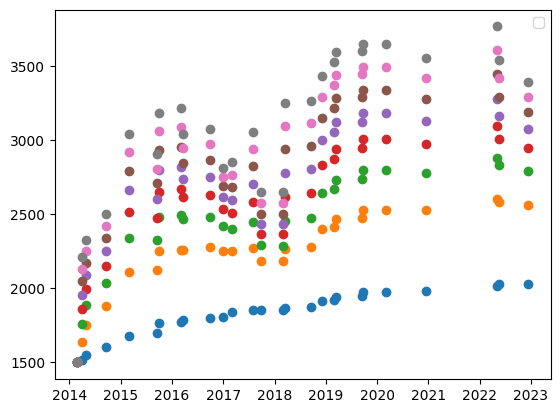

In [60]:
for k in range(10, 410, 50):
    plt.scatter(df_pro_open[df_pro_open['competitor_name'] == 'janet layug']['contest_date'],
                df_pro_open[df_pro_open['competitor_name'] == 'janet layug'][f'elo_{k}_rating'])
plt.legend()

In [64]:
for k in range(10, 410, 50):
    for idx, div in enumerate(['bikini', 'figure']):
        df_groupby = (df_pro_open[(df_pro_open['placing'] == 1) & (df_pro_open['division'] == div)]
                    .groupby(by = ['division', 'contest_date']))
        mean_elo_percentile = df_groupby[f'elo_{k}_percentile'].mean()
        mean_elo_percentile = mean_elo_percentile.reset_index()
        mean_elo_percentile[f'30day_{k}_rolling_avg'] = mean_elo_percentile[f'elo_{k}_percentile'].rolling(30).mean()
    
        print(f"k = {k}, division is {div}, and average is {mean_elo_percentile[f'30day_{k}_rolling_avg'].mean()}")

    # sns.lineplot(x='contest_date',
    #             y='30day_rolling_avg',
    #             data=mean_elo_percentile,
    #             palette='deep')
    # plt.legend()
    # plt.xticks(rotation=90);


k = 10, division is bikini, and average is 0.8617781854535324
k = 10, division is figure, and average is 0.8546427928803239
k = 60, division is bikini, and average is 0.8698746690147899
k = 60, division is figure, and average is 0.861980203504696
k = 110, division is bikini, and average is 0.8704453784000558
k = 110, division is figure, and average is 0.8607458530931342
k = 160, division is bikini, and average is 0.8705169096812077
k = 160, division is figure, and average is 0.8600249598809453
k = 210, division is bikini, and average is 0.8695754138536823
k = 210, division is figure, and average is 0.8589308122108644
k = 260, division is bikini, and average is 0.8686865396059826
k = 260, division is figure, and average is 0.8582881884586778
k = 310, division is bikini, and average is 0.8661674619712105
k = 310, division is figure, and average is 0.8578184943682167
k = 360, division is bikini, and average is 0.866009820465521
k = 360, division is figure, and average is 0.854710580547278

/var/folders/0s/9k5wnkxx22l_g6lmt5xw673m0000gq/T/ipykernel_27781/3683859537.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='contest_date',
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/0s/9k5wnkxx22l_g6lmt5xw673m0000gq/T/ipykernel_27781/3683859537.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='contest_date',
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


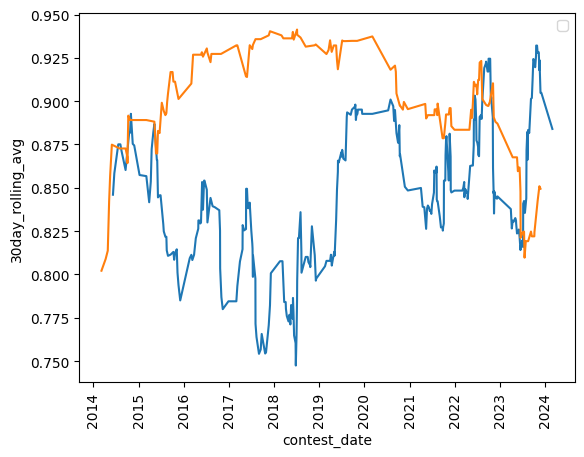

In [56]:
for idx, div in enumerate(['men\'s physique', 'men\'s bodybuilding']):
    df_groupby = (df_pro_open[(df_pro_open['placing'] == 1) & (df_pro_open['division'] == div)]
                  .groupby(by = ['division', 'contest_date']))
    mean_elo_percentile = df_groupby['elo_percentile'].mean()
    mean_elo_percentile = mean_elo_percentile.reset_index()
    mean_elo_percentile['30day_rolling_avg'] = mean_elo_percentile['elo_percentile'].rolling(30).mean()

    sns.lineplot(x='contest_date',
                y='30day_rolling_avg',
                data=mean_elo_percentile,
                palette='deep')
    plt.legend()
    plt.xticks(rotation=90);

In [31]:
df_pro_open['division'].value_counts()

division
bikini                    9273
men's physique            7864
figure                    5465
women's physique          3913
men's classic physique    3391
men's bodybuilding        2779
212                       2042
fitness                   1337
women's bodybuilding      1134
wellness                   921
women's wellness           188
Name: count, dtype: int64

In [13]:
for k in range(10, 300, 50):
    df_pro_open[f'elo_{k}_rank'] = df_pro_open.groupby(['contest_date', 'contest_name', 'division'])[f'elo_{k}_rating'].rank(ascending=False, method='first')
    df_pro_open.loc[df_pro_open[f'elo_{k}_rank'] > 16, f'elo_{k}_rank'] = 16

In [84]:
df_pro_open.tail()

,competitor_name,placing,contest_name,contest_date,division,elo_rating,elo_percentile,elo_rank,elo_10_rating,elo_10_percentile,...,elo_310_percentile,elo_360_rating,elo_360_percentile,elo_410_rating,elo_10_rank,elo_60_rank,elo_110_rank,elo_160_rank,elo_210_rank,elo_260_rank
74414,ren yi xie,6.0,ifbb professional league china dms pro shanghai,2024-03-01,men's physique,1500.000000,0.5625,4.0,1500.000000,0.5625,...,0.6875,1500.000000,0.6875,NaN,4.0,4.0,4.0,3.0,3.0,3.0
74415,xingwang yang,5.0,ifbb professional league china dms pro shanghai,2024-03-01,men's physique,1500.000000,0.5625,5.0,1500.000000,0.5625,...,0.6875,1500.000000,0.6875,NaN,5.0,5.0,5.0,4.0,4.0,4.0
74416,abdullah al salem,4.0,ifbb professional league china dms pro shanghai,2024-03-01,men's physique,1530.254944,0.8750,2.0,1500.646795,0.7500,...,0.8750,1512.350775,0.8750,NaN,3.0,3.0,2.0,2.0,2.0,2.0
74417,yiming wei,3.0,ifbb professional league china dms pro shanghai,2024-03-01,men's physique,1513.489760,0.7500,3.0,1519.870221,1.0000,...,0.5000,1451.684278,0.5000,NaN,1.0,2.0,3.0,5.0,5.0,5.0
74419,carlos asiedu ocran,1.0,ifbb professional league china dms pro shanghai,2024-03-01,men's physique,1408.432332,0.3750,6.0,1482.297860,0.3750,...,0.3750,1314.684267,0.3750,NaN,6.0,6.0,6.0,6.0,6.0,6.0


<Axes: >

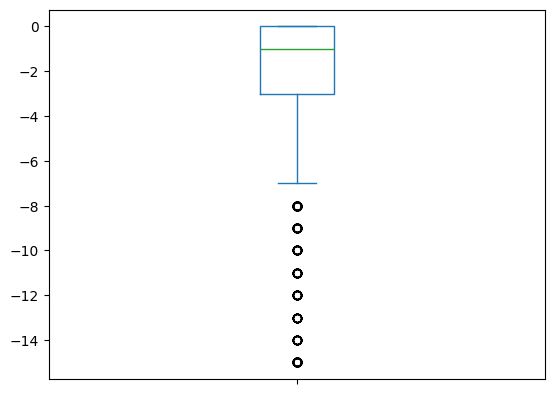

In [85]:
(df_pro_open[df_pro_open['placing'] == 1]['placing'] - df_pro_open[df_pro_open['placing'] == 1]['elo_rank']).plot.box()

In [42]:
rows_list = []
for div in df_pro_open['division'].unique():
    for dt in df_pro_open['contest_date'].unique():
        temp_df = df_pro_open[df_pro_open['contest_date'] == dt]
        scores = []
        scores_random = []
        for ctst in temp_df['contest_name'].unique():
            temp_df_2 = temp_df[(temp_df['contest_name'] == ctst) & (temp_df['division'] == div)]
            temp_df_2 = temp_df_2.dropna()
            if len(temp_df_2) < 2:
                continue
            y_true = temp_df_2['placing']
            y_predict = temp_df_2['elo_60_rank']
            scores.append(ndcg_score([y_true], [y_predict], ignore_ties=True))
            y_predict = list(y_predict)
            random.shuffle(y_predict)
            scores_random.append(ndcg_score([y_true], [y_predict], ignore_ties=True))
        if scores:
            rows_list.append({'date': dt, 'ndcg_score': sum(scores) / len(scores), 'ndcg_score_random': sum(scores_random) / len(scores_random), 'division': div})

In [47]:
ndcg_df = pd.DataFrame(rows_list)
ndcg_df['30_day_rolling_avg'] = ndcg_df.groupby('division')['ndcg_score'].transform(lambda x: x.rolling(10, 10).mean())
ndcg_df['30_day_rolling_avg_random'] = ndcg_df.groupby('division')['ndcg_score_random'].transform(lambda x: x.rolling(10, 10).mean())

Text(0, 0.5, '30-day Rolling Average NDCG Scores')

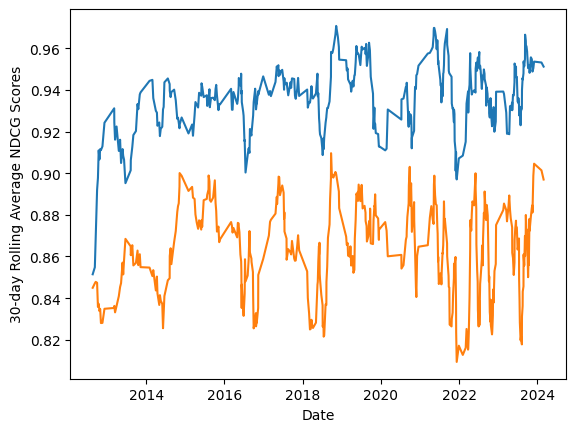

In [55]:
ax = sns.lineplot(data=ndcg_df[ndcg_df['division'] == 'bikini'], x='date', y='30_day_rolling_avg')
ax2 = sns.lineplot(data=ndcg_df[ndcg_df['division'] == 'bikini'], x='date', y='30_day_rolling_avg_random')
plt.xlabel('Date')
plt.ylabel('30-day Rolling Average NDCG Scores')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [66]:
rows_list = []
for div in df_pro_open['division'].unique():
    for dt in df_pro_open['contest_date'].unique():
        temp_df = df_pro_open[df_pro_open['contest_date'] == dt]
        scores = []
        pvalues = []
        scores_random = []
        pvalues_random = []
        for ctst in temp_df['contest_name'].unique():
            temp_df_2 = temp_df[(temp_df['contest_name'] == ctst) & (temp_df['division'] == div)]
            temp_df_2 = temp_df_2.dropna()
            if len(temp_df_2) < 2:
                continue
            y_true = temp_df_2['placing']
            y_predict = temp_df_2['elo_60_rank']
            scores.append(kendalltau(y_true, y_predict).statistic)
            pvalues.append(kendalltau(y_true, y_predict).pvalue)
            y_predict = list(y_predict)
            random.shuffle(y_predict)
            scores_random.append(kendalltau(y_true, y_predict).statistic)
            pvalues_random.append(kendalltau(y_true, y_predict).pvalue)
        if scores:
            rows_list.append({'date': dt,
                              'kendalltau_score': sum(scores) / len(scores),
                              'kendalltau_score_random': sum(scores_random) / len(scores_random),
                              'kendalltau_pvalue': sum(pvalues) / len(pvalues),
                              'kendalltau_pvalue_random': sum(pvalues_random) / len(pvalues_random),
                              'division': div})

In [67]:
kendalltau_df = pd.DataFrame(rows_list)
kendalltau_df['30_day_rolling_avg_kendalltau'] = kendalltau_df.groupby('division')['kendalltau_score'].transform(lambda x: x.rolling(10, 10).mean())
kendalltau_df['30_day_rolling_avg_random_kendalltau'] = kendalltau_df.groupby('division')['kendalltau_score_random'].transform(lambda x: x.rolling(10, 10).mean())
kendalltau_df['30_day_rolling_avg_kendalltau_pvalue'] = kendalltau_df.groupby('division')['kendalltau_pvalue'].transform(lambda x: x.rolling(10, 10).mean())
kendalltau_df['30_day_rolling_avg_random_kendalltau_pvalue'] = kendalltau_df.groupby('division')['kendalltau_pvalue_random'].transform(lambda x: x.rolling(10, 10).mean())

Text(0, 0.5, '30-day Rolling Average Kendall Tau Correlation Statistic')

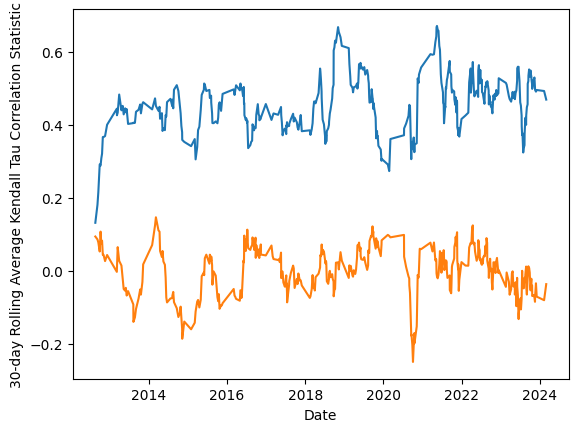

In [68]:
ax = sns.lineplot(data=kendalltau_df[kendalltau_df['division'] == 'bikini'], x='date', y='30_day_rolling_avg_kendalltau')
ax2 = sns.lineplot(data=kendalltau_df[kendalltau_df['division'] == 'bikini'], x='date', y='30_day_rolling_avg_random_kendalltau')
plt.xlabel('Date')
plt.ylabel('30-day Rolling Average Kendall Tau Correlation Statistic')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

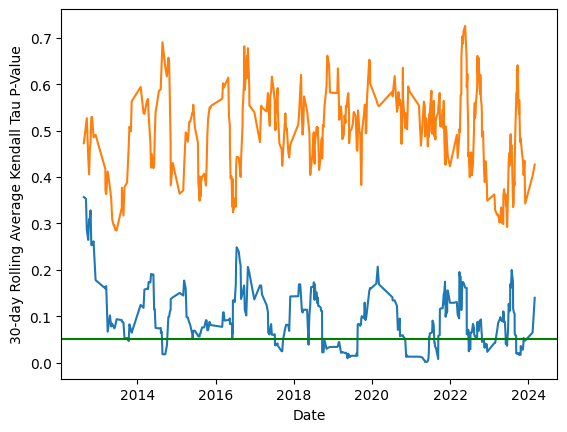

In [75]:
ax = sns.lineplot(data=kendalltau_df[kendalltau_df['division'] == 'bikini'], x='date', y='30_day_rolling_avg_kendalltau_pvalue')
ax2 = sns.lineplot(data=kendalltau_df[kendalltau_df['division'] == 'bikini'], x='date', y='30_day_rolling_avg_random_kendalltau_pvalue')
plt.xlabel('Date')
plt.ylabel('30-day Rolling Average Kendall Tau P-Value')
plt.axhline(0.05, color='green')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [126]:
rows_list = []
for div in df_pro_open['division'].unique():
    for dt in df_pro_open['contest_date'].unique():
        temp_df = df_pro_open[df_pro_open['contest_date'] == dt]
        scores = []
        scores_random = []
        for ctst in temp_df['contest_name'].unique():
            temp_df_2 = temp_df[(temp_df['contest_name'] == ctst) & (temp_df['division'] == div)]
            temp_df_2 = temp_df_2.dropna()
            if len(temp_df_2) < 2:
                continue
            top_10_placing = temp_df_2.sort_values(by=['placing'], ascending=True).head(10)
            top_10_elo = temp_df_2.sort_values(by=['elo_60_rank'], ascending=True).head(10)
            scores.append(0.1 * len(pd.merge(top_10_placing, top_10_elo, how='inner', on=['competitor_name'])))
            top_10_random = temp_df_2.sample(frac=1).head(10)
            scores_random.append(0.1 * len(pd.merge(top_10_placing, top_10_random, how='inner', on=['competitor_name'])))
        if scores:
            rows_list.append({'date': dt,
                              'precision_10_score': sum(scores) / len(scores),
                              'precision_10_score_random': sum(scores_random) / len(scores_random),
                              'division': div})

In [127]:
precision_10_df = pd.DataFrame(rows_list)
precision_10_df['30_day_rolling_avg_precision_10'] = precision_10_df.groupby('division')['precision_10_score'].transform(lambda x: x.rolling(30, 30).mean())
precision_10_df['30_day_rolling_avg_random_precision_10'] = precision_10_df.groupby('division')['precision_10_score_random'].transform(lambda x: x.rolling(30, 30).mean())

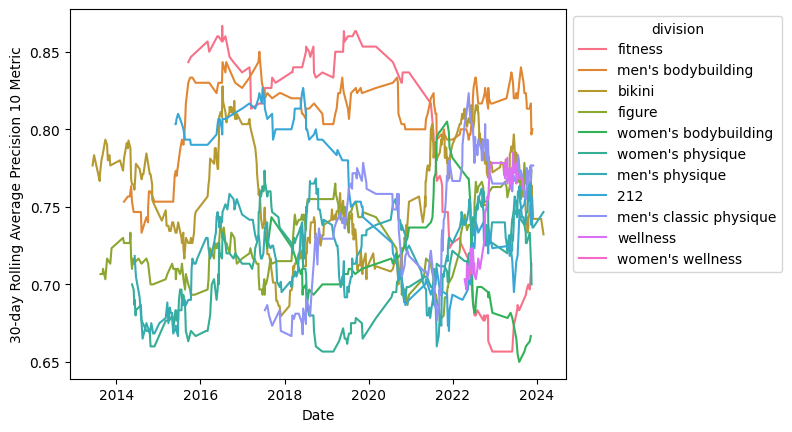

In [128]:
ax = sns.lineplot(data=precision_10_df, x='date', y='30_day_rolling_avg_precision_10', hue='division')
plt.xlabel('Date')
plt.ylabel('30-day Rolling Average Precision 10 Metric')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

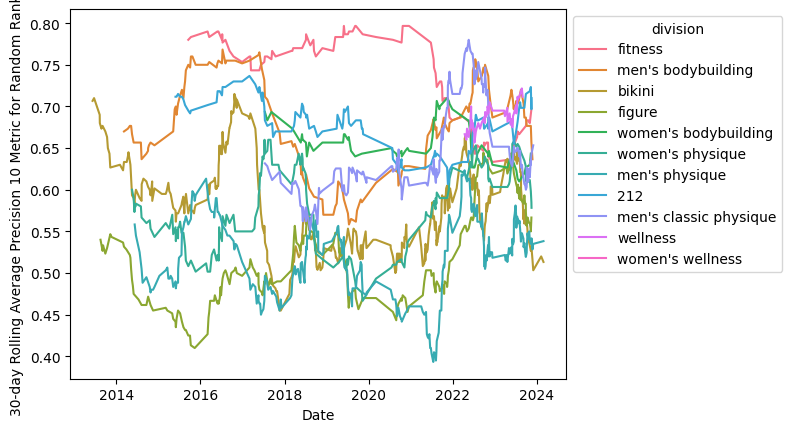

In [129]:
ax = sns.lineplot(data=precision_10_df, x='date', y='30_day_rolling_avg_random_precision_10', hue='division')
plt.xlabel('Date')
plt.ylabel('30-day Rolling Average Precision 10 Metric for Random Ranking')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))